In [29]:
import json
import torch
import numpy as np
from transformers import AutoModelForMaskedLM, AutoModelForCausalLM, AutoTokenizer, T5Tokenizer, T5ForConditionalGeneration
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
from collections import Counter

In [5]:
tokenizer = AutoTokenizer.from_pretrained('albert-xxlarge-v2')
model = AutoModelForMaskedLM.from_pretrained('albert-xxlarge-v2')

In [6]:
data = [json.loads(line) for line in open('data/Google_RE/place_of_birth_test.jsonl')]
# data = [{'input_str': ' '.join(item['masked_sentences']), 'label': item['obj_label']} for item in data]
data = [{'input_str': f'{item["sub_label"]} was born in {tokenizer.mask_token}.', 'label': item['obj_label']} for item in data]

In [4]:
data[103]

{'input_str': 'Ali Sarmini was born in [MASK].', 'label': 'Aleppo'}

(array([   4.,  258., 1436.,  809.,  280.,   94.,   32.,   10.,    8.,
           6.]),
 array([23. , 26.9, 30.8, 34.7, 38.6, 42.5, 46.4, 50.3, 54.2, 58.1, 62. ]),
 <BarContainer object of 10 artists>)

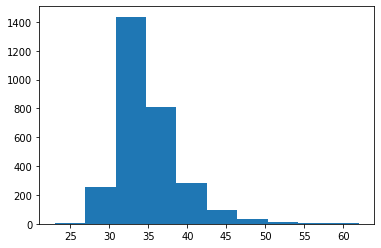

In [12]:
plt.hist([len(item['input_str']) for item in data])

In [7]:
p_1 = []
n_masks = []
for i, item in enumerate(tqdm(data)):
    inputs = tokenizer(item['input_str'], return_tensors='pt', truncation=True, max_length=512)
    label = tokenizer(item['label'], add_special_tokens=False)['input_ids'] # ' ' + item['label'] for roberta
    if len(label) != 1: 
        print(i)
        print(item['label'], label)
        continue
    label = label[0]
    mask_idxs = [i for i, token_id in enumerate(inputs['input_ids'][0]) if token_id == tokenizer.mask_token_id]
    n_masks.append(len(mask_idxs))
    outputs = model(**inputs)
    logits = outputs.logits[0][mask_idxs].mean(0)
    top_pred = logits.argmax(0).item()
    # print(tokenizer.decode([top_pred]), item['label'])
    p_1.append(top_pred == label)


 12%|█▏        | 351/2937 [03:00<21:32,  2.00it/s]

351
Westphalia [13, 22774]


 26%|██▌       | 756/2937 [06:28<18:33,  1.96it/s]

756
Calais [13, 25129]


 26%|██▋       | 772/2937 [06:36<18:01,  2.00it/s]

772
Aston [28, 444]


 32%|███▏      | 927/2937 [07:54<16:34,  2.02it/s]

927
Erie [13, 8337]


 40%|███▉      | 1168/2937 [09:57<15:11,  1.94it/s]

1168
Easton [342, 218]


 51%|█████▏    | 1509/2937 [12:56<13:15,  1.79it/s]

1509
Holstein [13, 20422]


 52%|█████▏    | 1518/2937 [13:00<11:58,  1.97it/s]

1518
Erie [13, 8337]


 58%|█████▊    | 1693/2937 [14:30<10:42,  1.94it/s]

1693
Calais [13, 25129]


 64%|██████▍   | 1877/2937 [16:04<09:13,  1.91it/s]

1877
Bari [13, 11650]


 77%|███████▋  | 2260/2937 [19:19<05:36,  2.01it/s]

2260
Ventura [13, 18290]


 78%|███████▊  | 2281/2937 [19:29<05:28,  2.00it/s]

2281
Holstein [13, 20422]


 88%|████████▊ | 2570/2937 [22:03<03:08,  1.95it/s]

2570
Bari [13, 11650]


100%|██████████| 2937/2937 [25:11<00:00,  1.94it/s]


In [19]:
# vocab = [line.strip() for line in open('data/common_vocab_cased.txt')]
# allowed_token_ids = [tokenizer(token, add_special_tokens=False)['input_ids'][0] for token in vocab]

# p_1 = []
# n_masks = []
# for i, item in enumerate(tqdm(data)):
#     inputs = tokenizer(item['input_str'], return_tensors='pt', truncation=True, max_length=512)
#     label = tokenizer(item['label'], add_special_tokens=False)['input_ids']
#     if len(label) != 1: 
#         print(i)
#         print(label)
#         continue
#     label = label[0]
#     mask_idxs = [i for i, token_id in enumerate(inputs['input_ids'][0]) if token_id == tokenizer.mask_token_id]
#     n_masks.append(len(mask_idxs))
#     outputs = model(**inputs)
#     logits = outputs.logits[0][mask_idxs].mean(0)
#     logits[allowed_token_ids] += 1e3
#     top_pred = logits.argmax(0).item()
#     p_1.append(top_pred == label)
    

100%|██████████| 2937/2937 [05:13<00:00,  9.38it/s]


In [28]:
len(p_1), np.mean(p_1)

(2404, 0.07321131447587355)

In [ ]:
Birthplace 0.4123255022131427
Deathplace 0.283289817232376
Birthdate 0.03397260273972603

# Causal LM

In [34]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModelForCausalLM.from_pretrained('gpt2')

In [35]:
data = [json.loads(line) for line in open('data/Google_RE/place_of_birth_test.jsonl')]
data = [{'input_str': f'{item["sub_label"]} was born in', 'label': item['obj_label']} for item in data]

In [36]:
p_1 = []
n_masks = []
for i, item in enumerate(tqdm(data)):
    inputs = tokenizer(item['input_str'], return_tensors='pt', truncation=True, max_length=512)
    label = tokenizer(' ' + item['label'], add_special_tokens=False)['input_ids']
    if len(label) != 1: 
        # print(i)
        # print(item['label'], label)
        continue
    label = label[0]
    outputs = model(**inputs)
    logits = outputs.logits[0]
    top_pred = logits[-1].argmax().item()
    # print(logits.shape)
    # print(tokenizer.decode([top_pred]), item['label'])
    # input()

    p_1.append(top_pred == label)


100%|██████████| 2937/2937 [01:56<00:00, 25.26it/s]


In [38]:
len(p_1), np.mean(p_1)

(2404, 0.0)

In [46]:
[tokenizer.decode([id]) for id in tokenizer(data[2]['input_str'])['input_ids']]

['John', 'Stephen', 'was', 'born', 'in', '<extra_id_0>', '', '.', '</s>']

In [48]:
tokenizer(data[2]['input_str'])

{'input_ids': [1079, 7872, 47, 2170, 16, 32099, 3, 5, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

# Seq2seq

In [55]:
tokenizer = T5Tokenizer.from_pretrained('t5-3b')
model = T5ForConditionalGeneration.from_pretrained('t5-3b')

In [56]:
data = [json.loads(line) for line in open('data/Google_RE/place_of_birth_test.jsonl')]
data = [{'input_str': f'{item["sub_label"]} was born in <extra_id_0>.', 'label': item['obj_label']} for item in data]

In [ ]:
p_1 = []
n_masks = []
for i, item in enumerate(tqdm(data)):
    
    label = tokenizer(item['label'], add_special_tokens=False)['input_ids']
    if len(label) != 1: 
        # print(i)
        # print(item['label'], label)
        continue
    label = label[0]

    input_ids = tokenizer(item['input_str'], return_tensors='pt', truncation=True, max_length=512).input_ids
    input_labels = tokenizer('<extra_id_0> _ </s>', return_tensors='pt').input_ids
    outputs = model(input_ids=input_ids, labels=input_labels, return_dict=True)
    logits = outputs['logits'][0, 1]
    
    top_pred = logits.argmax().item()
    # print(logits.shape)
    # print(tokenizer.decode([top_pred]), item['label'])
    # input()

    p_1.append(top_pred == label)

